In [3]:
# importing dependencies
import pandas as pd # data frame
import numpy as np # matrix math
from scipy.io import wavfile # reading the wavfile
import os # interation with the OS
from sklearn.utils import shuffle # shuffling of data
from random import sample # random selection
import matplotlib.pyplot as plt # to view graphs

# audio processing
from scipy import signal # audio processing
from scipy.fftpack import dct


In [13]:
PATH = './train/audio/'

In [98]:
def log_spectogram(audio, sample_rate, window_size=20, 
                 step_size=10, eps=1e-10):
    
    frame_length = int(round(window_size * sample_rate / 1e3))
    frame_step = int(round(step_size * sample_rate / 1e3))
    
    signal_length = len(audio)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(audio, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
    
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) +\
        np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # hamming window
    frames *= np.hamming(frame_length)

    NFFT = 2048
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    
    spec = pow_frames.T
    
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
            
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    return np.log(spec.astype(np.float32) + eps), filter_banks.T

def audio_to_log_spect(path):
    # we take a single path and convert it into data
    sample_rate, audio = wavfile.read(path)
    pre_emphasis = 0.97
    emphasized_signal = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])
    spectrogram = log_spectogram(emphasized_signal, sample_rate, 20)
    return spectrogram

[['stop' 'stop/37fc5d97_nohash_1.wav']
 ['two' 'two/493392c6_nohash_0.wav']
 ['off' 'off/92a9c5e6_nohash_2.wav']
 ['nine' 'nine/7be9f58a_nohash_0.wav']]


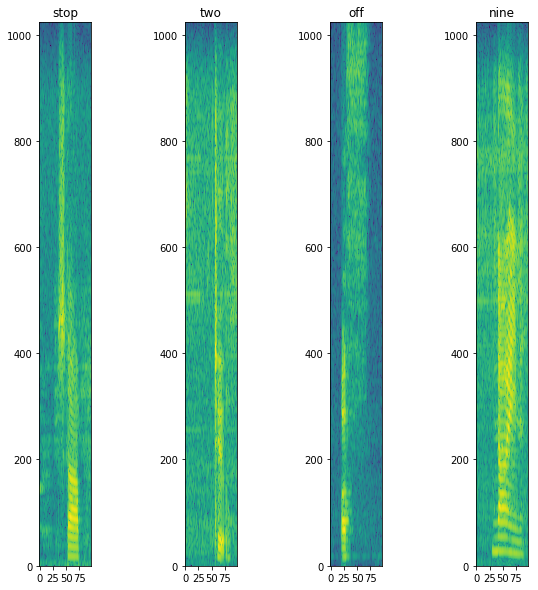

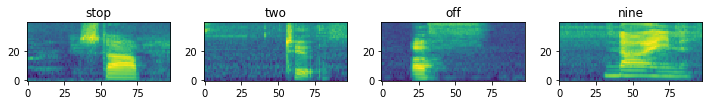

In [110]:
train = pd.read_csv('train_files.csv')
files = train[['all_labels','file_path']].sample(4)
print(files.values)

sample_files = PATH + files['file_path'].values

fig, axes = plt.subplots(nrows=1, ncols=4)

fig2, axes2 = plt.subplots(nrows=1, ncols=4)
fig2.set_figheight(10)
fig2.set_figwidth(10)

for label, sample, ax, ax2 in zip(files['all_labels'].values, sample_files, axes.flat, axes2.flat):
    ax.set_title(label)
    ax2.set_title(label)
    
    log_spect, log_mel_spect = audio_to_log_spect(sample)
    
    ax.imshow(log_spect)
    ax2.imshow(log_mel_spect)
    
    ax.invert_yaxis()
    ax2.invert_yaxis()
    
    ax.set_xticks(np.arange(0, log_spect.shape[1]+1, 25))
    
# fig.tight_layout()
fig2.tight_layout()
plt.show()

## MFCC and Filter Bank Sample

I learned it from Haytham Fayek's excellent blog post on the topic. You can read it at http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html.

In [111]:
def mfcc_features(path_file, frame_size, frame_stride):
    sample_rate, signal = wavfile.read(path_file)
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # params
    '''frame_size = 0.025
    frame_stride = 0.01'''
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) +\
        np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # hamming window
    frames *= np.hamming(frame_length)

    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    num_ceps = 20
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    
    cep_lifter = 22
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift  #*
    
    return filter_banks, mfcc

def normalized_fb(fb):
    fb -= (np.mean(fb, axis=0) + 1e-8)
    return fb

def normalized_mfcc(mfcc):
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    return mfcc